In [ ]:
!pip install little_mallet_wrapper

In [ ]:
# Import core libraries
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk, seaborn as sns
import pprint
import little_mallet_wrapper
from tqdm.notebook import tqdm
tqdm.pandas()
import glob

# Gensim
import gensim
# import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel
np.random.seed(1) # setting random seed to get the same results each time.
from gensim.models import ldamodel

# spacy for lemmatization
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 40000000

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Hellinger, JS & Divergence
from gensim.matutils import hellinger
from gensim.matutils import kullback_leibler
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#/content/drive/MyDrive/Brazil/JS Divergent/data/Tiktok_Anti
import re
import openpyxl
depth_data = []
for file in glob.glob('/content/drive/MyDrive/Brazil/JS Divergent/data/Tiktok_Anti/*'):
    xlsx_file = re.search('.xlsx', file)
    csv_file = re.search('.csv', file)
    xls_file = re.search('.xls', file)
    if (xlsx_file or xls_file):
        df = pd.read_excel(file, engine='openpyxl')
    elif csv_file:
        df = pd.read_csv(file)
    depth_data.append(df)
master_data = pd.concat(depth_data)

In [ ]:
def generate_corpus(df):
    for column in df.columns:
        if column == "caption":
            df.caption = df.caption.astype(str)
            df["corpus"] = df["caption"].apply(lambda x: little_mallet_wrapper.process_string(x, numbers='remove'))
        elif column == "video_title":
            df.video_title = df.video_title.astype(str)
            df["corpus"] = df["translated_caption"].apply(lambda x: little_mallet_wrapper.process_string(x, numbers='remove'))
        elif column == "description":
            df.description = df.description.astype(str)
            df["corpus"] = df["Translated_Caption"].apply(lambda x: little_mallet_wrapper.process_string(x, numbers='remove'))
        elif column == "transcript":
            df.transcript = df.transcript.astype(str)
            df["corpus"] = df["transcript"].apply(lambda x: little_mallet_wrapper.process_string(x, numbers='remove'))
    return df

In [ ]:
depth_data

[    id                date                                            caption  \
 0    1 2022-12-30 00:37:33  #lagrancolombia🇵🇦🇨🇴🇪🇨🇻🇪 #colombiaaaaaa #brazil...   
 1    2 2022-12-31 22:37:26  #SOSBRAZIL #BrazilwAsstolen #MoninhaBandeiraja...   
 2    3 2022-12-29 19:59:49  How to put out this fire, Generals? The Sovere...   
 3    4 2022-12-28 12:40:35  What happened yesterday late afternoon and ear...   
 4    5 2022-12-31 17:27:14                  Live President Bolsonaro 12/30/22   
 5    6 2022-12-27 19:28:45  Suggestion to all countries that don't want co...   
 6    7 2022-12-30 15:44:03  #sosbrazil #brazilwasstolen #minhabandeiramais...   
 7    8 2022-12-30 15:28:38  All the left wants is to use this to inflame t...   
 8    9 2022-12-29 11:34:52  PTistas don't seem to want NINE! #fouryou #tik...   
 9   10 2022-12-29 13:15:37  Vent! #fouryou #tiktok #eua #ny #eleicoes2022 ...   
 10  11 2022-12-30 08:45:10  #bolsonaro #liberdade #michellebolsonaro #braz...   
 11  12 2022-12-

In [ ]:
# Clean master doc
df_master_corpus = generate_corpus(master_data)

# Clean depth docs
df_week_corpus = []
for Week in depth_data:
    df_week_corpus.append(generate_corpus(Week))

In [ ]:
df_master_corpus.columns

Index(['id', 'date', 'caption', 'week', 'corpus'], dtype='object')

In [ ]:
df_week_corpus

[    id                date                                            caption  \
 0    1 2022-12-30 00:37:33  #lagrancolombia🇵🇦🇨🇴🇪🇨🇻🇪 #colombiaaaaaa #brazil...   
 1    2 2022-12-31 22:37:26  #SOSBRAZIL #BrazilwAsstolen #MoninhaBandeiraja...   
 2    3 2022-12-29 19:59:49  How to put out this fire, Generals? The Sovere...   
 3    4 2022-12-28 12:40:35  What happened yesterday late afternoon and ear...   
 4    5 2022-12-31 17:27:14                  Live President Bolsonaro 12/30/22   
 5    6 2022-12-27 19:28:45  Suggestion to all countries that don't want co...   
 6    7 2022-12-30 15:44:03  #sosbrazil #brazilwasstolen #minhabandeiramais...   
 7    8 2022-12-30 15:28:38  All the left wants is to use this to inflame t...   
 8    9 2022-12-29 11:34:52  PTistas don't seem to want NINE! #fouryou #tik...   
 9   10 2022-12-29 13:15:37  Vent! #fouryou #tiktok #eua #ny #eleicoes2022 ...   
 10  11 2022-12-30 08:45:10  #bolsonaro #liberdade #michellebolsonaro #braz...   
 11  12 2022-12-

In [ ]:
# Stemming and Lemmatization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
df_week_corpus

[    id                date                                            caption  \
 0    1 2022-12-30 00:37:33  #lagrancolombia🇵🇦🇨🇴🇪🇨🇻🇪 #colombiaaaaaa #brazil...   
 1    2 2022-12-31 22:37:26  #SOSBRAZIL #BrazilwAsstolen #MoninhaBandeiraja...   
 2    3 2022-12-29 19:59:49  How to put out this fire, Generals? The Sovere...   
 3    4 2022-12-28 12:40:35  What happened yesterday late afternoon and ear...   
 4    5 2022-12-31 17:27:14                  Live President Bolsonaro 12/30/22   
 5    6 2022-12-27 19:28:45  Suggestion to all countries that don't want co...   
 6    7 2022-12-30 15:44:03  #sosbrazil #brazilwasstolen #minhabandeiramais...   
 7    8 2022-12-30 15:28:38  All the left wants is to use this to inflame t...   
 8    9 2022-12-29 11:34:52  PTistas don't seem to want NINE! #fouryou #tik...   
 9   10 2022-12-29 13:15:37  Vent! #fouryou #tiktok #eua #ny #eleicoes2022 ...   
 10  11 2022-12-30 08:45:10  #bolsonaro #liberdade #michellebolsonaro #braz...   
 11  12 2022-12-

In [ ]:
# Master corpus
data_word_master = list(sent_to_words(df_master_corpus["corpus"]))

# Depth corpus
data_word_depth = []
for depth_corpus in df_week_corpus:
    data_word_depth.append(list(sent_to_words(depth_corpus["corpus"])))

In [ ]:
## Build the bigram and trigram models (Master and Depth Corpora)

# Master Corpus
bigram_master = gensim.models.Phrases(data_word_master, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_master = gensim.models.Phrases(bigram_master[data_word_master], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_master = gensim.models.phrases.Phraser(bigram_master)
trigram_mod_master = gensim.models.phrases.Phraser(trigram_master)


# Depths Corpus
bigram_depth = []
trigram_depth = []
bigram_mod_depth = []
trigram_mod_depth = []

for data_word in data_word_depth:
    bigram_depth.append(gensim.models.Phrases(data_word, min_count=5, threshold=100)) # higher threshold fewer phrases.

for data_word, bigram_depth_data in zip(data_word_depth, bigram_depth):
    trigram_depth.append(gensim.models.Phrases(bigram_depth_data[data_word], threshold=100))

# Faster way to get a sentence clubbed as a trigram/bigram
for bi_item in bigram_depth:
    bigram_mod_depth.append(gensim.models.phrases.Phraser(bi_item))

for tri_item in trigram_depth:
    trigram_mod_depth.append(gensim.models.phrases.Phraser(tri_item))

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Master Corpus
def make_bigrams_master(texts):
    return [bigram_mod_master[doc] for doc in texts]

def make_trigrams_master(texts):
    return [trigram_mod_master[bigram_mod_master[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Lemmatization of Master corpus

# Remove Stop Words
data_words_nostops_master = remove_stopwords(data_word_master)
# Form Bigrams
data_words_bigrams_master = make_bigrams_master(data_words_nostops_master)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_master = lemmatization(data_words_bigrams_master, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Lemmatization of Depth corpus

data_words_nostops = []
for data_word in data_word_depth:
    data_words_nostops.append(remove_stopwords(data_word))

data_words_bigrams = []
for data_nostops in data_words_nostops:
    data_words_bigrams.append(make_bigrams_master(data_nostops))

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_depth = []

for data_word in data_words_bigrams:
    data_lemmatized_depth.append(lemmatization(data_word, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))

In [ ]:
text_master = data_lemmatized_master
text_depths = data_lemmatized_depth

# Building an LDA_model using the master corpus
dictionary = Dictionary(data_lemmatized_master)
corpus_master = [dictionary.doc2bow(text) for text in text_master]
model = ldamodel.LdaModel(corpus_master, id2word=dictionary, num_topics=10, minimum_probability=1e-8)

In [ ]:
model.show_topics()

[(0,
  '0.062*"brasil" + 0.060*"eleicoe" + 0.022*"bolsonaro" + 0.017*"tiktok" + 0.012*"believe" + 0.009*"miracle" + 0.008*"bbclondon_euronew" + 0.008*"foxnews_nytime" + 0.008*"spanish" + 0.008*"restrict"'),
 (1,
  '0.046*"brasil" + 0.027*"eleicoe" + 0.011*"tiktok" + 0.011*"dictatorship" + 0.011*"fouryou" + 0.011*"foryoupage" + 0.011*"happen" + 0.010*"see" + 0.010*"brazilian" + 0.009*"attack"'),
 (2,
  '0.032*"bolsonaro" + 0.027*"brazilriot" + 0.011*"brazilian" + 0.010*"lula" + 0.009*"foryoupage" + 0.009*"intervention" + 0.009*"military" + 0.009*"politicstiktok" + 0.009*"arrest" + 0.009*"article"'),
 (3,
  '0.064*"brasil" + 0.057*"eleicoe" + 0.020*"tiktok" + 0.013*"fouryou" + 0.013*"movement" + 0.013*"foxnews_nytime" + 0.013*"bbclondon_euronew" + 0.013*"patriot" + 0.012*"miracle" + 0.010*"brazilwasstolen"'),
 (4,
  '0.026*"bolsonaro" + 0.018*"brazilian" + 0.018*"brazilwasstolen" + 0.018*"brazilpatriot" + 0.018*"lulapresidente" + 0.017*"fyp" + 0.017*"patriot" + 0.017*"brasil" + 0.010*"lu

In [ ]:
doc_corpus = []
bow_depth = []
lda_bows = []
for lemm_depth in data_lemmatized_depth:
    doc_corpus.append(sum(lemm_depth, []))

for doc in doc_corpus:
    bow_depth.append(model.id2word.doc2bow(doc))

for bow in bow_depth:
    lda_bows.append(model[bow])

In [ ]:
# Specify depth distance
#depths = ["45-46", "46-47", "47-48", "48-49", "49-50", "50-51", "51-52", "52-53", "53-1", "1-2", "2-3", "3-4", "4-5", "5-6"]
depths = ["50-51", "51-52", "52-53", "53-1", "1-2", "2-3", "3-4", "4-5", "5-6"]
#depths = ["51-53", "53-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10"]
#depths = ["51-52", "52-53", "53-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10"]
# seed_depths = ["0-1", "0-2", "0-3", "0-4", "0-5"]

In [ ]:
# Compute Hellinger scores
interdepth_hellinger_scores = []
for i in range(len(lda_bows) - 1):
    mark = i + 1
    if not (mark <= len(lda_bows)):
        break
    else:
        score = hellinger(lda_bows[i], lda_bows[mark])
        interdepth_hellinger_scores.append(score)

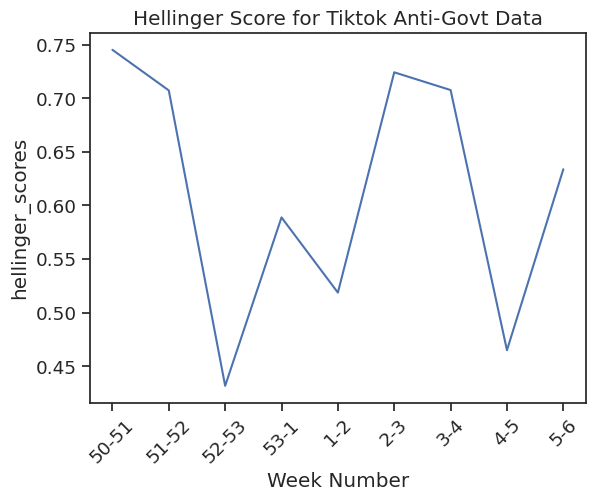

<Figure size 1500x800 with 0 Axes>

In [ ]:
# Plot Hellinger scores with Seaborn (intertopic hellinger distance)
depth_hellinger = pd.DataFrame({"Week Number": depths, "hellinger_scores": interdepth_hellinger_scores})
hellinger_plot = sns.lineplot(x="Week Number", y="hellinger_scores", data=depth_hellinger)
hellinger_plot.set_title('Hellinger Score for Tiktok Anti-Govt Data')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.figure(figsize = (15,8))
plt.show()

In [ ]:
# Function to compute JS Scores
def js_score(p, q):
    num = [i + j for i, j in zip(p, q)]
    for val in num:
        if (type(val) == float):
            p_prob = p
            q_prob = q
        else:
            p_prob = [prob for index, prob in p]
            q_prob = [prob for index, prob in q]
    # find m & z
    m = [x + y for x, y in zip(p_prob, q_prob)]
    z = [1/2 * i for i in m]
    # find the kullback distance between p-z & q-z
    kl_pz = round(kullback_leibler(p_prob, z), 6)
    kl_qz = round(kullback_leibler(q_prob, z), 6)
    # compute js_score
    js_score = math.sqrt((kl_pz + kl_qz) / 2)
    return js_score

In [ ]:
# Compute JS scores
js_master_scores = []
for item in range(len(lda_bows) - 1):
    mark = item + 1
    if not (mark <= len(lda_bows)):
        break
    else:
        score = js_score(lda_bows[item], lda_bows[mark])
        js_master_scores.append(score)

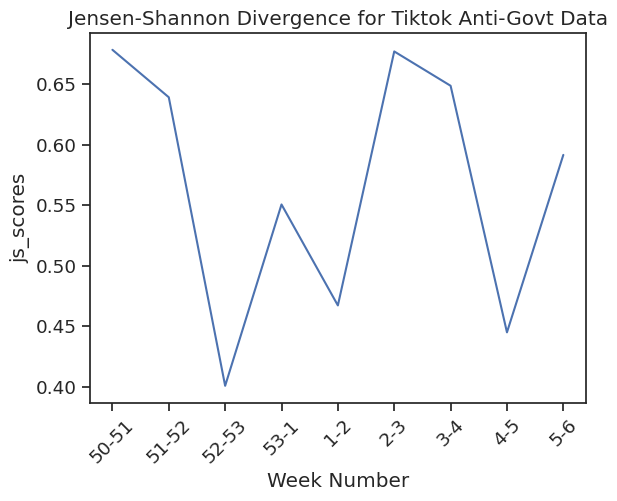

<Figure size 1500x800 with 0 Axes>

In [ ]:
# Plot JS scores with Seaborn
depth_js = pd.DataFrame({"Week Number": depths, "js_scores": js_master_scores})
js_plot = sns.lineplot(x="Week Number", y="js_scores", data=depth_js)
js_plot.set_title('Jensen-Shannon Divergence for Tiktok Anti-Govt Data');
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.figure(figsize = (15,8))
plt.show()